# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

/tmp/ipykernel_6654/3389954195.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html_content)
/tmp/ipykernel_6654/3389954195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Streams'] = df['Streams'].astype(float)
/tmp/ipykernel_6654/3389954195.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["Song", "Artist(s)", "Streams", "Release date"], inplace=True)
/tmp/ipykernel_6654/3389954195.

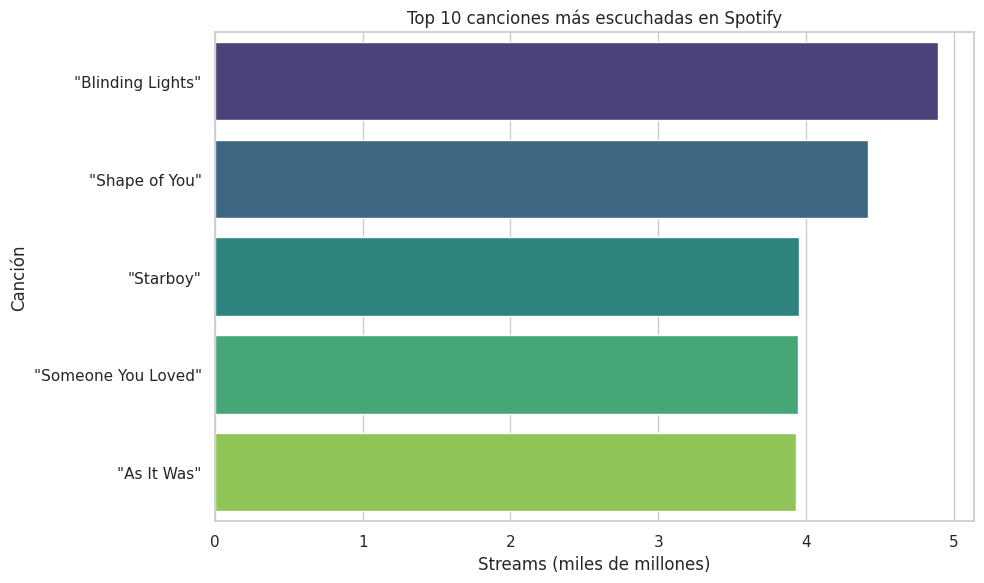

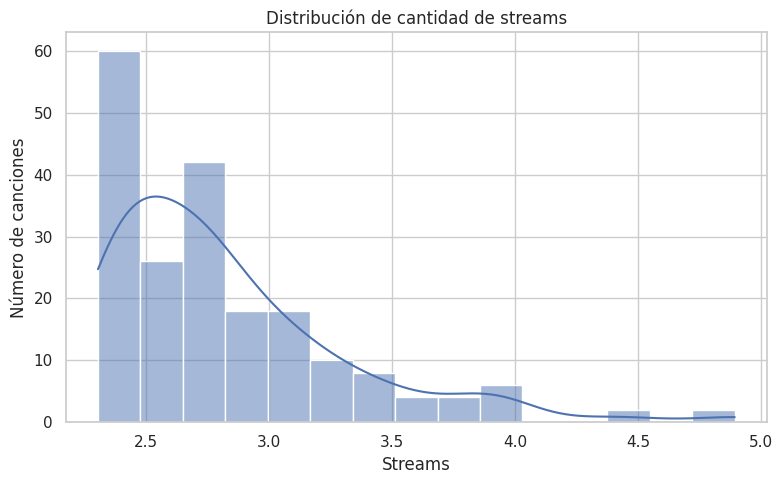

/tmp/ipykernel_6654/3389954195.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette="rocket")


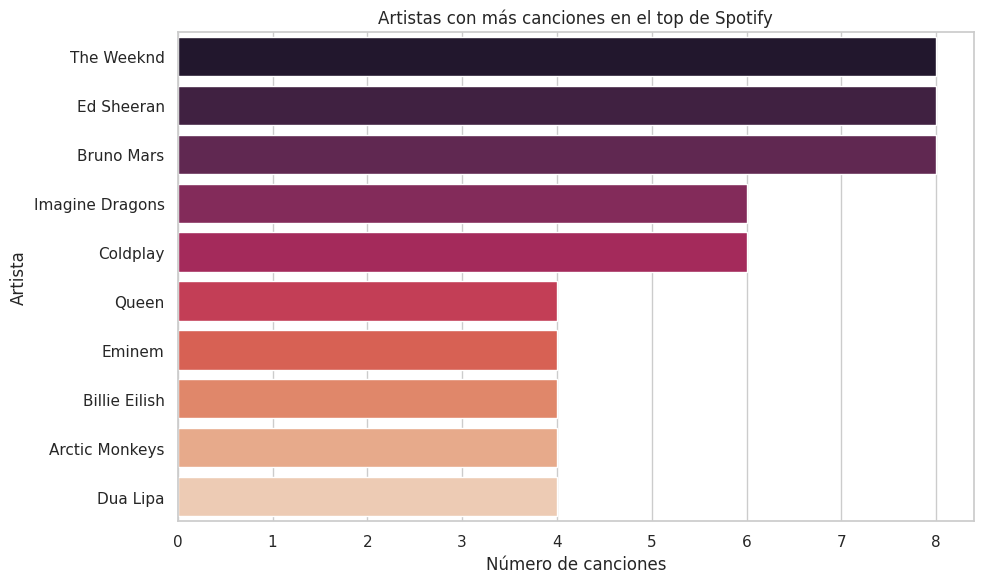

In [16]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)
html_content = response.text

tables = pd.read_html(html_content)
df = tables[0]  

df.columns = [col.strip() for col in df.columns]
df.rename(columns={"Streams (billions)": "Streams"}, inplace=True)


df['Streams'] = df['Streams'].astype(str)
df = df[df['Streams'].str.contains(r'^\d+\.?\d*$', na=False)]  
df['Streams'] = df['Streams'].astype(float)


df.dropna(subset=["Song", "Artist(s)", "Streams", "Release date"], inplace=True)

conn = sqlite3.connect('spotify_top_songs.db')
cursor = conn.cursor()


cursor.execute('''
    CREATE TABLE IF NOT EXISTS songs (
        rank INTEGER PRIMARY KEY AUTOINCREMENT,
        song TEXT,
        artist TEXT,
        streams REAL,
        release_date TEXT
    )
''')


for _, row in df.iterrows():
    cursor.execute('''
        INSERT INTO songs (song, artist, streams, release_date)
        VALUES (?, ?, ?, ?)
    ''', (row['Song'], row['Artist(s)'], row['Streams'], row['Release date']))

conn.commit()
conn.close()


conn = sqlite3.connect('spotify_top_songs.db')
df_sql = pd.read_sql_query("SELECT * FROM songs", conn)
conn.close()

sns.set(style="whitegrid")
top_10 = df_sql.sort_values(by="streams", ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x="streams", y="song", data=top_10, palette="viridis")
plt.title("Top 10 canciones más escuchadas en Spotify")
plt.xlabel("Streams (miles de millones)")
plt.ylabel("Canción")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_sql['streams'], bins=15, kde=True)
plt.title("Distribución de cantidad de streams")
plt.xlabel("Streams")
plt.ylabel("Número de canciones")
plt.tight_layout()
plt.show()

top_artists = df_sql['artist'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette="rocket")
plt.title("Artistas con más canciones en el top de Spotify")
plt.xlabel("Número de canciones")
plt.ylabel("Artista")
plt.tight_layout()
plt.show()








